# Music generation with Auto-Encoder

Build a 2 layers auto-encoder with TensorFlow to generate music with a lower latent space and construct them.

- Author: Antoine Drabble
- Project: https://github.com/drabble/???

Sources : 

- https://keras.io/examples/generative/vae/
- https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
- https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8


TODO :

- Try to replace the velocity of a note with a duration instead (so we have long notes)
- Is it possible to have duration as well as velocity, should this be a second network or lstm somehow?
- Put back the csv generation in here
- Push on github
- Clean up the code a bit more
- Add the decode part so we can generate from a z distribution

## Imports

In [1]:
# Midi and audio
import midi #pip install git+https://github.com/vishnubob/python-midi@feature/python3
from music21 import converter

# Machine learning
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# Plots
import matplotlib.pyplot as plt

# Files
from pathlib import Path
import os

In [2]:
WIDTH = 64 # Width of the track
HEIGHT = 20 # Height of track (number of notes/octaves)
OFFSET = 65 # Starting note from the lowest midi note
INTERVAL = 128 # Minimum number of ticks between two notes

BATCH_SIZE = 50 # Batch size
LATENT_SPACE = 12 # Size of latent layer mu and sigma
EPOCHS = 300

## Read dataset

In [3]:
result = list(Path("./vg_piano").rglob("*.[mM][iI][dD]"))
dataset = []
array = []

# For each file in the folder
for x in range(len(result)):
    try:
        array = np.zeros(WIDTH * HEIGHT) # File data
        pattern = midi.read_midifile(result[x].as_posix()) # Read midi file
        
        # For each track (piano, drum...)
        for i in range(len(pattern)):
            tickCount = 0 # Compute ticks between each note
        
            # For each event (note on, note off, etc.) in the track
            for j in range(len(pattern[i])):
                
                # Add the tick of the note to tick count
                if type(pattern[i][j]) is midi.NoteOnEvent or type(pattern[i][j]) is midi.NoteOffEvent:
                    tickCount += pattern[i][j].tick
                    
                # If we reach the max width of dataset stop
                if math.floor(tickCount / INTERVAL) >= WIDTH:
                    break
                    
                # If it's a NoteOn, the tick is more than 0 (otherwise all instruments play a note!) 
                # and channel is not drum and we are within the note height and offset
                if type(pattern[i][j]) is midi.NoteOnEvent and pattern[i][j].tick >= 0 and pattern[i][j].channel != 10 and pattern[i][j].data[0] < HEIGHT + OFFSET and pattern[i][j].data[1] > 0 and pattern[i][j].data[0] >= OFFSET:
                    
                    ## Find when the note stops
                    #noteLength = 1 # One is like 1000 ticks
                    #tickCount2 = tickCount
                    ## Go through the following notes to find the NoteOff
                    #for k in range(j, len(pattern[i])): 
                    #    # If the note is on or off, we add the ticks
                    #    if type(pattern[i][k]) is midi.NoteOnEvent or type(pattern[i][k]) is midi.NoteOffEvent:
                    #        tickCount2 += pattern[i][k].tick
                    #    # If we reach max distance we stop
                    #    if tickCount2 > 1000:
                    #        break
                    #    # if it is the same note and an event NoteOff or (NoteOn with 0 velocity) 
                    #    if pattern[i][j].data[0] == pattern[i][k].data[0] and (type(pattern[i][k]) is midi.NoteOffEvent or (type(pattern[i][k]) is midi.NoteOnEvent and pattern[i][k].data[1] == 0)):
                    #        noteLength = tickCount2 / 1000 
                    #        break;
            
                    # Set note with its length as value
                    array[(pattern[i][j].data[0] - OFFSET) * WIDTH + math.floor(tickCount / INTERVAL)] = min(pattern[i][j].data[1] / 100, 1)
                    
        dataset.append(array)
    except Exception as e:
        print("ERROR: ", e)
print("DONE ", len(result), " midi files")
np.savetxt("dataset.csv", np.array(dataset), fmt='%10.2f', delimiter=",")

DONE  730  midi files


In [4]:
print(midi.read_midifile(result[2].as_posix()))

midi.Pattern(format=1, resolution=960, tracks=\
[midi.Track(\
  [midi.SequencerSpecificEvent(tick=0, data=[5, 15, 18, 0, 0, 107, 127, 0, 7, 1]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 28, 50, 48, 48, 55, 46, 49, 48, 46, 48, 50]),
   midi.KeySignatureEvent(tick=0, data=[0, 0]),
   midi.TrackNameEvent(tick=0, text='Track 0', data=[84, 114, 97, 99, 107, 32, 48]),
   midi.SetTempoEvent(tick=0, data=[6, 26, 128]),
   midi.EndOfTrackEvent(tick=0, data=[])]),
 midi.Track(\
  [midi.SequencerSpecificEvent(tick=0, data=[5, 15, 9, 0, 64]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 6, 71, 101, 110, 101, 114, 97, 108, 32, 77, 73, 68, 73]),
   midi.TrackNameEvent(tick=0, text='Right Hand', data=[82, 105, 103, 104, 116, 32, 72, 97, 110, 100]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 16, 0]),
   midi.ProgramChangeEvent(tick=0, channel=0, data=[0]),
   midi.ChannelPrefixEvent(tick=0, data=[0]),
   midi.NoteOnEvent(tick=7680, channel=0, data=[74, 89]),
   midi.NoteOffE

### Read some midi tracks from the dataset

In [5]:
def generateTrack(data):
    # Instantiate a MIDI Pattern (contains a list of tracks)
    p = midi.Pattern()
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    p.append(track)
    # Instantiate a MIDI note on event, append it to the track
    tickCount = 0
    track.append(midi.NoteOnEvent(tick=0, velocity=100, pitch=60))
    track.append(midi.NoteOnEvent(tick=100, velocity=100, pitch=60))
    
    # We will create a second array for notes off based on length of each note
    dataNotesOff = np.zeros(WIDTH * HEIGHT)
    for x in range(WIDTH):
        for y in range(HEIGHT):
            if data[y * WIDTH + x] > 0.5 and y * WIDTH + x + 1 + data[y * WIDTH + x] * 1000 / INTERVAL < WIDTH * HEIGHT:
                dataNotesOff[int(y * WIDTH + x + 1 + data[y * WIDTH + x] * 1000 / INTERVAL)] = 1

    for x in range(WIDTH):
        for y in range(HEIGHT):
            # Add note off
            if dataNotesOff[y * WIDTH + x] > 0:
                track.append(midi.NoteOffEvent(tick=tickCount, velocity=0, pitch=OFFSET + y))
                tickCount = 0
            # Add note on
            if data[y * WIDTH + x] > 0.05:
                track.append(midi.NoteOnEvent(tick=tickCount, velocity=100, pitch=OFFSET + y))
                tickCount = 0
        tickCount += INTERVAL
    # Add the end of track event, append it to the track
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    return p

def generateTrackImage(data):
        canvas_orig = np.empty((HEIGHT, WIDTH))
        for j in range(WIDTH * HEIGHT):
            # Draw the midi notes
            canvas_orig[int(j / WIDTH), j % WIDTH] = data[j]
        print("Original Images")   
        plt.figure(figsize=(5,20))  
        plt.imshow(canvas_orig, origin="upper", cmap="gray")
        plt.show()

vg_piano/GameCornerRag.mid
Original Images


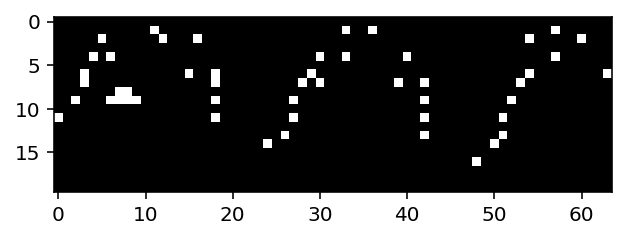

vg_piano/TheSims_TheNeighborhood_Piano.mid
Original Images


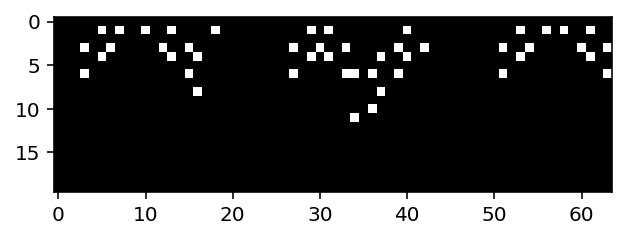

vg_piano/chocomountainpiano.mid
Original Images


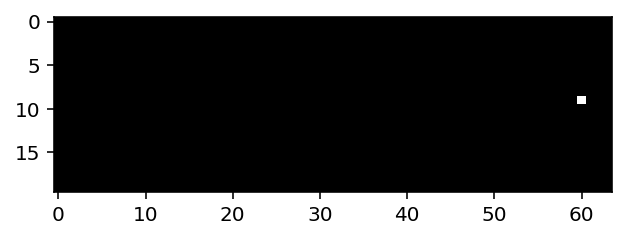

vg_piano/TjsS2OP.mid
Original Images


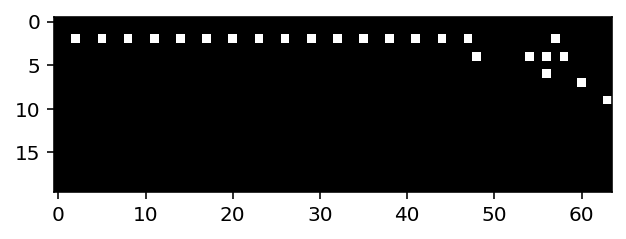

vg_piano/SaveCottagespiano.mid
Original Images


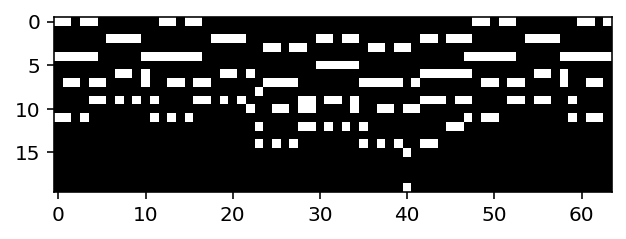

vg_piano/rozen-maiden-kodoku-na-kokoro.mid
Original Images


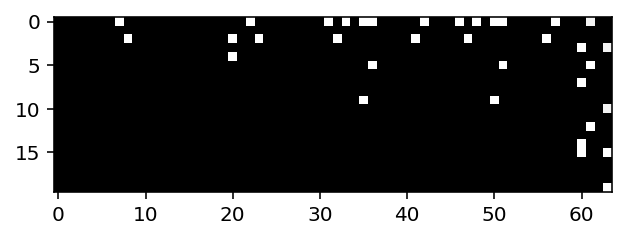

vg_piano/Mario_3.mid
Original Images


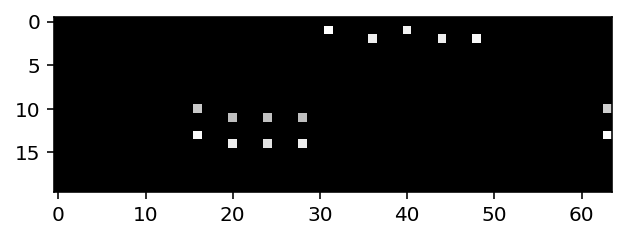

vg_piano/DemonCastlePinnacle.mid
Original Images


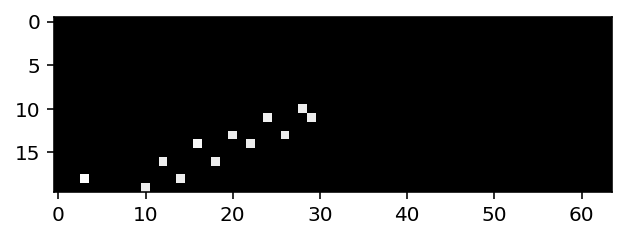

vg_piano/Windfall_Island.mid
Original Images


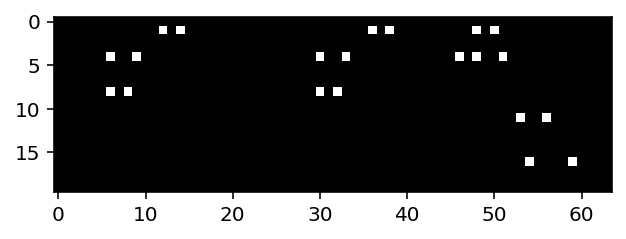

vg_piano/Route_12.mid
Original Images


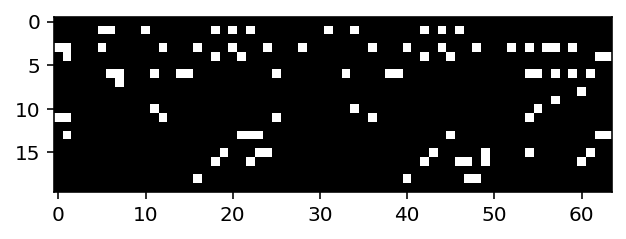

midi.Pattern(format=1, resolution=220, tracks=\
[midi.Track(\
  [midi.NoteOnEvent(tick=0, channel=0, data=[60, 100]),
   midi.NoteOnEvent(tick=100, channel=0, data=[60, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[76, 100]),
   midi.NoteOffEvent(tick=128, channel=0, data=[67, 0]),
   midi.NoteOffEvent(tick=0, channel=0, data=[70, 0]),
   midi.NoteOnEvent(tick=128, channel=0, data=[74, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[71, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[72, 100]),
   midi.NoteOffEvent(tick=128, channel=0, data=[68, 0]),
   midi.NoteOnEvent(tick=0, channel=0, data=[69, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[67, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[69, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[74, 100]),
   midi.NoteOffEvent(tick=128, channel=0, data=[72, 0]),
   midi.NoteOnEvent(tick=0, channel=0, data=[73, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[74, 100]),
   midi.NoteOnEvent(tick=128, 

In [6]:
for i in range(10):
    print(result[i].as_posix())
    
    pattern = generateTrack(dataset[i]);
    
    # Save the pattern to disk
    filename = "./generated/" + str(i) + ".mid"
    midi.write_midifile(filename, pattern)

    generateTrackImage(dataset[i])
    
    s = converter.parse(result[i].as_posix())
    s.show('midi')
    s = converter.parse(filename)
    s.show('midi')
    
print(midi.read_midifile("./generated/" + str(0) + '.mid'))

## Load dataset from csv

In [7]:
train_dataset_fp = np.genfromtxt(r"dataset.csv",delimiter=",")

x_train = train_dataset_fp[0:500].astype('float32')
x_test = train_dataset_fp[500:600].astype('float32')

## Configure neural network

### Layers

In [8]:
def sample_z(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)), mean=0., stddev=1.0)
    return z_mean + keras.backend.exp(z_log_var / 2) * eps

# Q(z|X) -- encoder
encoder_inputs = keras.layers.Input(shape=x_train[0].shape, name = 'encoder_inputs')
encoder_hidden = keras.layers.Dense(512, activation='relu', name = 'encoder_hidden')(encoder_inputs)
z_mean = keras.layers.Dense(LATENT_SPACE, activation='linear', name = 'z_mean')(encoder_hidden)
z_log_var = keras.layers.Dense(LATENT_SPACE, activation='linear', name = 'z_log_var')(encoder_hidden)
# Sample z ~ Q(z|X)
z = keras.layers.Lambda(sample_z, name = 'z_latent_space')([z_mean, z_log_var])
# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder_partial = keras.Model(encoder_inputs, [z_mean, z_log_var], name = 'encoder_partial')
encoder = keras.Model(encoder_inputs, z, name = 'encoder')
encoder.summary()


# P(X|z) -- decoder
decoder_inputs = keras.layers.Input(shape = (LATENT_SPACE,), name = 'decoder_inputs')
decoder_hidden = keras.layers.Dense(512, activation='relu', name = 'decoder_hidden')(decoder_inputs)
decoder_outputs = keras.layers.Dense(x_train[0].shape[0], activation='sigmoid', name = 'decoder_outputs')(decoder_hidden)

decoder = keras.Model(decoder_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = keras.Model(encoder_inputs, decoder(z), name = 'vae')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 1280)]       0                                            
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 512)          655872      encoder_inputs[0][0]             
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 12)           6156        encoder_hidden[0][0]             
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 12)           6156        encoder_hidden[0][0]             
____________________________________________________________________________________________

### Loss function

In [9]:
def vae_loss(x, x_decoded_mean):
    z_mean, z_log_var = encoder_partial(x)
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(x, x_decoded_mean)
    )
    reconstruction_loss *= x_train[0].shape[0]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss)
    return reconstruction_loss + kl_loss

## Train VAE

In [10]:
print(x_train[0])
print(x_test[0])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]


In [11]:
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,clipnorm=1), 
    loss=vae_loss, 
    metrics=['accuracy'])
history = vae.fit(
    x_train, 
    x_train, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    epochs=EPOCHS)
print(history)

Epoch 1/300
10/10 [==============================] - 0s 28ms/step - loss: 446.7259 - accuracy: 0.0000e+00 - val_loss: 183.7539 - val_accuracy: 0.0000e+00
Epoch 2/300
10/10 [==============================] - 0s 12ms/step - loss: 188.5304 - accuracy: 0.0040 - val_loss: 161.7677 - val_accuracy: 0.0000e+00
Epoch 3/300
10/10 [==============================] - 0s 13ms/step - loss: 168.4269 - accuracy: 0.0020 - val_loss: 151.2182 - val_accuracy: 0.0100
Epoch 4/300
10/10 [==============================] - 0s 12ms/step - loss: 155.1225 - accuracy: 0.0020 - val_loss: 147.5165 - val_accuracy: 0.0100
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 149.9871 - accuracy: 0.0080 - val_loss: 143.3192 - val_accuracy: 0.0000e+00
Epoch 6/300
10/10 [==============================] - 0s 11ms/step - loss: 140.5390 - accuracy: 0.0120 - val_loss: 137.4722 - val_accuracy: 0.0200
Epoch 7/300
10/10 [==============================] - 0s 11ms/step - loss: 135.6401 - accuracy: 0.0200 - val_

Epoch 57/300
10/10 [==============================] - 0s 11ms/step - loss: 17.4645 - accuracy: 0.0860 - val_loss: 200.0664 - val_accuracy: 0.0100
Epoch 58/300
10/10 [==============================] - 0s 12ms/step - loss: 17.3895 - accuracy: 0.0700 - val_loss: 198.2508 - val_accuracy: 0.0200
Epoch 59/300
10/10 [==============================] - 0s 12ms/step - loss: 17.7550 - accuracy: 0.0780 - val_loss: 192.9172 - val_accuracy: 0.0300
Epoch 60/300
10/10 [==============================] - 0s 13ms/step - loss: 17.8089 - accuracy: 0.0900 - val_loss: 196.8278 - val_accuracy: 0.0100
Epoch 61/300
10/10 [==============================] - 0s 12ms/step - loss: 17.3087 - accuracy: 0.0840 - val_loss: 195.9379 - val_accuracy: 0.0100
Epoch 62/300
10/10 [==============================] - 0s 12ms/step - loss: 16.6746 - accuracy: 0.0740 - val_loss: 193.9625 - val_accuracy: 0.0300
Epoch 63/300
10/10 [==============================] - 0s 12ms/step - loss: 17.5502 - accuracy: 0.0840 - val_loss: 198.9960 -

Epoch 113/300
10/10 [==============================] - 0s 11ms/step - loss: 14.4119 - accuracy: 0.0880 - val_loss: 208.2712 - val_accuracy: 0.0000e+00
Epoch 114/300
10/10 [==============================] - 0s 12ms/step - loss: 14.4455 - accuracy: 0.0980 - val_loss: 208.9551 - val_accuracy: 0.0300
Epoch 115/300
10/10 [==============================] - 0s 12ms/step - loss: 13.8273 - accuracy: 0.0920 - val_loss: 226.0338 - val_accuracy: 0.0200
Epoch 116/300
10/10 [==============================] - 0s 12ms/step - loss: 14.0130 - accuracy: 0.0760 - val_loss: 205.0250 - val_accuracy: 0.0300
Epoch 117/300
10/10 [==============================] - 0s 11ms/step - loss: 13.7996 - accuracy: 0.0760 - val_loss: 214.4599 - val_accuracy: 0.0100
Epoch 118/300
10/10 [==============================] - 0s 11ms/step - loss: 14.0232 - accuracy: 0.0900 - val_loss: 214.4839 - val_accuracy: 0.0200
Epoch 119/300
10/10 [==============================] - 0s 13ms/step - loss: 13.5855 - accuracy: 0.1140 - val_loss:

10/10 [==============================] - 0s 16ms/step - loss: 12.7046 - accuracy: 0.0920 - val_loss: 233.5466 - val_accuracy: 0.0100
Epoch 169/300
10/10 [==============================] - 0s 14ms/step - loss: 12.9271 - accuracy: 0.0880 - val_loss: 227.4657 - val_accuracy: 0.0100
Epoch 170/300
10/10 [==============================] - 0s 17ms/step - loss: 13.1023 - accuracy: 0.0940 - val_loss: 241.5636 - val_accuracy: 0.0000e+00
Epoch 171/300
10/10 [==============================] - 0s 16ms/step - loss: 15.8693 - accuracy: 0.0920 - val_loss: 217.2995 - val_accuracy: 0.0100
Epoch 172/300
10/10 [==============================] - 0s 15ms/step - loss: 13.0806 - accuracy: 0.0860 - val_loss: 220.1344 - val_accuracy: 0.0300
Epoch 173/300
10/10 [==============================] - 0s 18ms/step - loss: 13.3471 - accuracy: 0.0780 - val_loss: 217.2218 - val_accuracy: 0.0200
Epoch 174/300
10/10 [==============================] - 0s 18ms/step - loss: 12.4835 - accuracy: 0.0900 - val_loss: 228.6197 - va

10/10 [==============================] - 0s 15ms/step - loss: 12.1051 - accuracy: 0.1020 - val_loss: 235.5413 - val_accuracy: 0.0100
Epoch 224/300
10/10 [==============================] - 0s 16ms/step - loss: 12.6896 - accuracy: 0.1120 - val_loss: 231.4805 - val_accuracy: 0.0200
Epoch 225/300
10/10 [==============================] - 0s 16ms/step - loss: 12.3125 - accuracy: 0.1020 - val_loss: 221.6778 - val_accuracy: 0.0100
Epoch 226/300
10/10 [==============================] - 0s 15ms/step - loss: 11.6091 - accuracy: 0.0720 - val_loss: 249.2050 - val_accuracy: 0.0000e+00
Epoch 227/300
10/10 [==============================] - 0s 15ms/step - loss: 12.6884 - accuracy: 0.0940 - val_loss: 216.2665 - val_accuracy: 0.0300
Epoch 228/300
10/10 [==============================] - 0s 15ms/step - loss: 15.2436 - accuracy: 0.0880 - val_loss: 229.5881 - val_accuracy: 0.0100
Epoch 229/300
10/10 [==============================] - 0s 16ms/step - loss: 12.8087 - accuracy: 0.0960 - val_loss: 232.0314 - va

10/10 [==============================] - 0s 21ms/step - loss: 11.9568 - accuracy: 0.1000 - val_loss: 204.0543 - val_accuracy: 0.0200
Epoch 279/300
10/10 [==============================] - 0s 24ms/step - loss: 11.2124 - accuracy: 0.1040 - val_loss: 239.5009 - val_accuracy: 0.0000e+00
Epoch 280/300
10/10 [==============================] - 0s 19ms/step - loss: 11.2578 - accuracy: 0.0920 - val_loss: 217.4957 - val_accuracy: 0.0000e+00
Epoch 281/300
10/10 [==============================] - 0s 24ms/step - loss: 11.2955 - accuracy: 0.0940 - val_loss: 236.8288 - val_accuracy: 0.0100
Epoch 282/300
10/10 [==============================] - 0s 22ms/step - loss: 11.7910 - accuracy: 0.0780 - val_loss: 231.8769 - val_accuracy: 0.0100
Epoch 283/300
10/10 [==============================] - 0s 21ms/step - loss: 11.5610 - accuracy: 0.0860 - val_loss: 221.4946 - val_accuracy: 0.0100
Epoch 284/300
10/10 [==============================] - 0s 22ms/step - loss: 11.0778 - accuracy: 0.0880 - val_loss: 244.7272 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


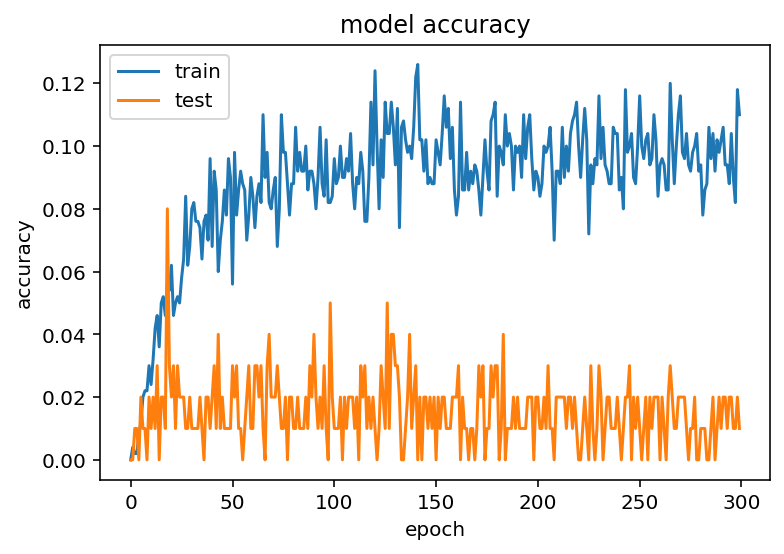

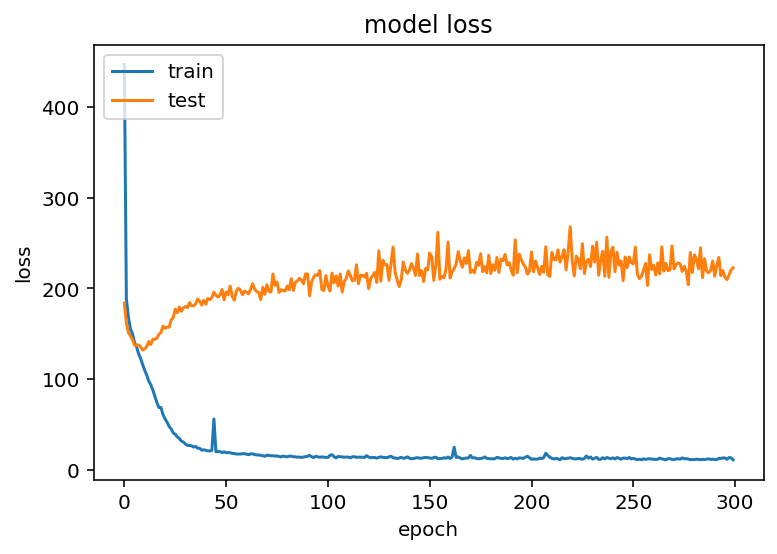

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

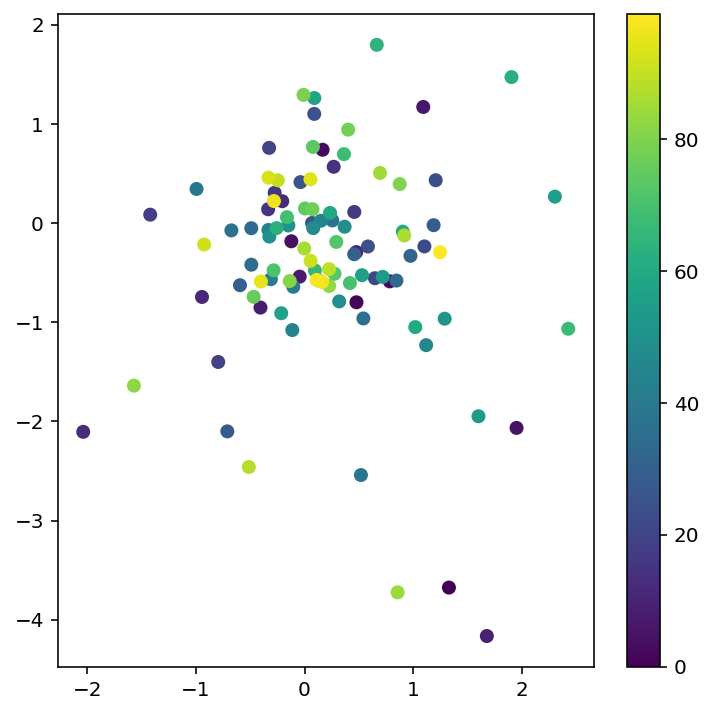

In [13]:
# build a model to project inputs on the latent space
# This is pretty much useless, but we can see that the latent variables follow more or less the norma distribution
x_test_encoded = encoder.predict(x_test, batch_size=BATCH_SIZE)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=range(BATCH_SIZE*2))
plt.colorbar()
plt.show()

## Evaluate trained model

In [14]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = vae.evaluate(x_test, x_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 3ms/step - loss: 218.5828 - accuracy: 0.0200
test loss, test acc: [218.58282470703125, 0.019999999552965164]


# Generate predictions (probabilities -- the output of the last layer)

Generate predictions for samples
(100, 1280)
predictions shape: (100, 1280)
Original
x_test_0.mid
Original Images


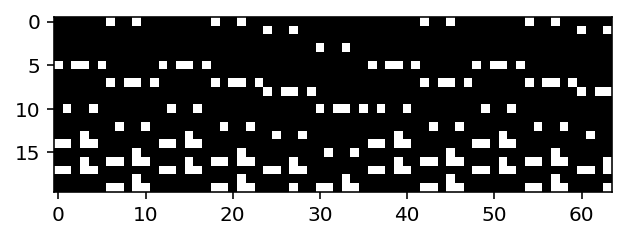

./generated/x_test_0.mid


Reproduction
Original Images


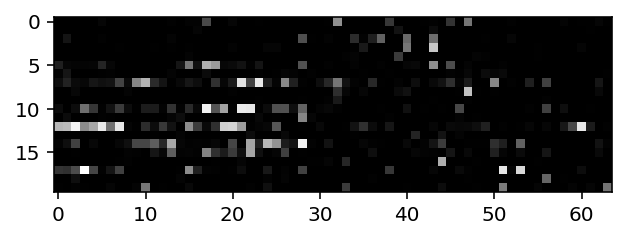

./generated/prediction_0.mid


Original
x_test_1.mid
Original Images


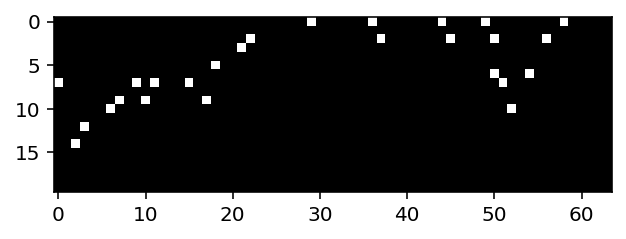

./generated/x_test_1.mid


Reproduction
Original Images


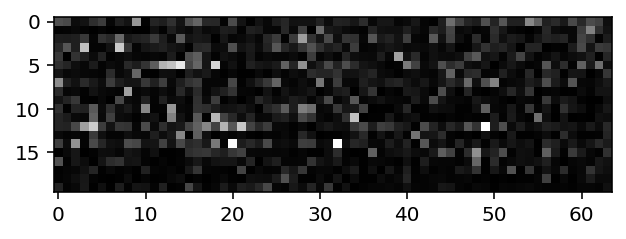

./generated/prediction_1.mid


Original
x_test_2.mid
Original Images


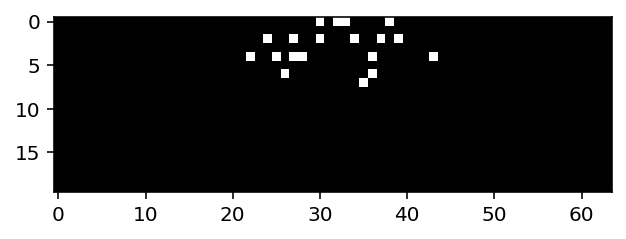

./generated/x_test_2.mid


Reproduction
Original Images


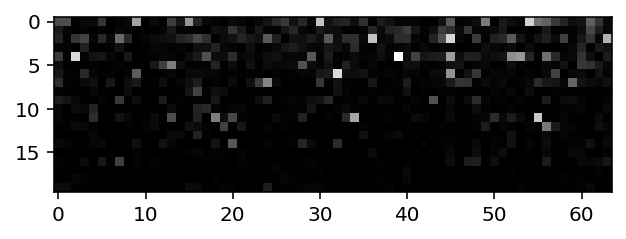

./generated/prediction_2.mid


Original
x_test_3.mid
Original Images


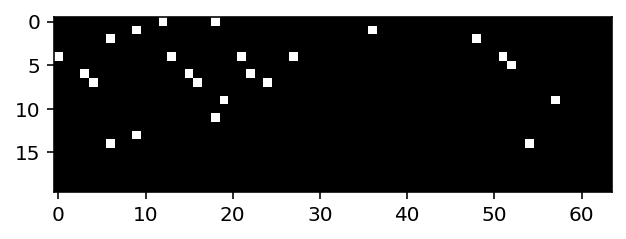

./generated/x_test_3.mid


Reproduction
Original Images


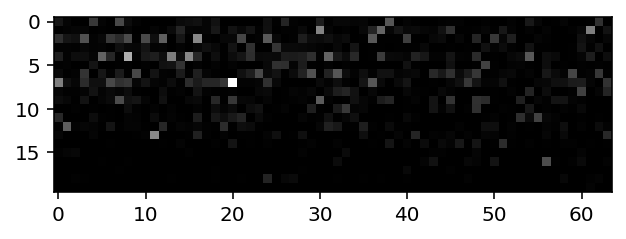

./generated/prediction_3.mid


Original
x_test_4.mid
Original Images


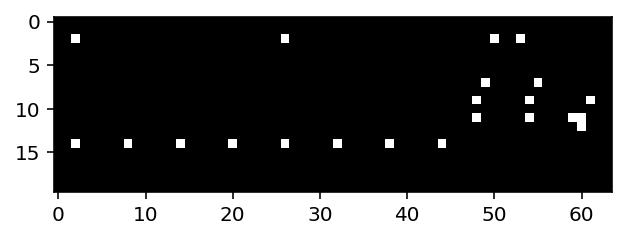

./generated/x_test_4.mid


Reproduction
Original Images


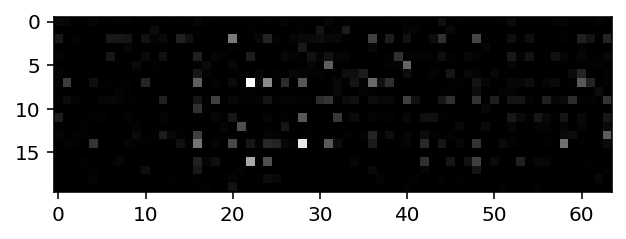

./generated/prediction_4.mid


Original
x_test_5.mid
Original Images


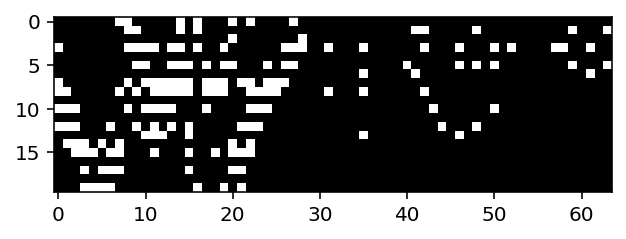

./generated/x_test_5.mid


Reproduction
Original Images


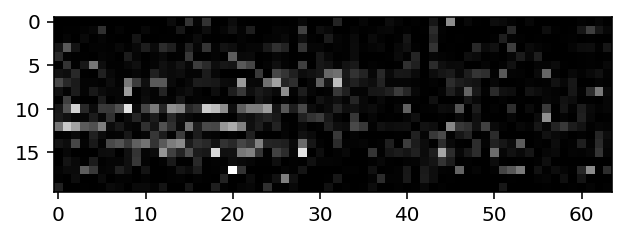

./generated/prediction_5.mid


Original
x_test_6.mid
Original Images


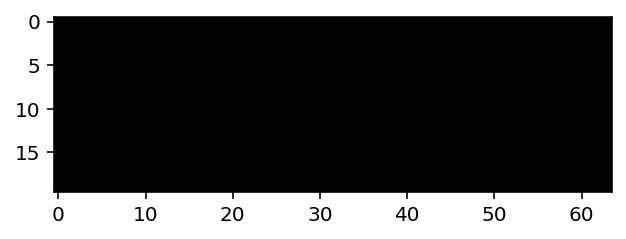

./generated/x_test_6.mid


Reproduction
Original Images


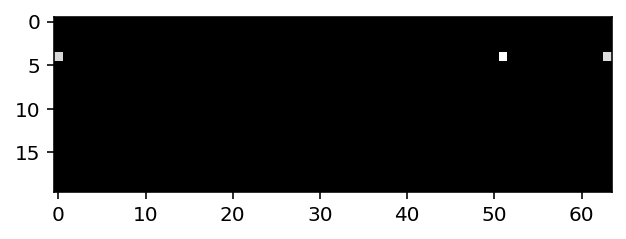

./generated/prediction_6.mid


Original
x_test_7.mid
Original Images


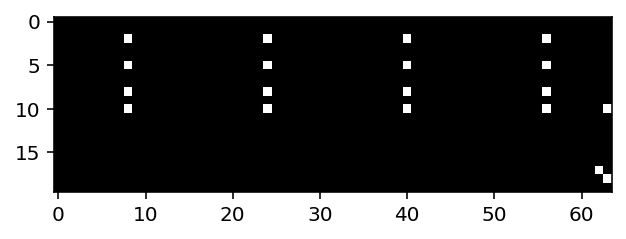

./generated/x_test_7.mid


Reproduction
Original Images


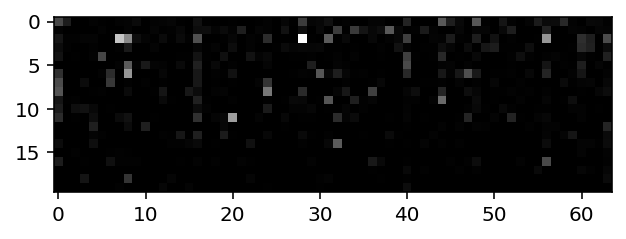

./generated/prediction_7.mid


Original
x_test_8.mid
Original Images


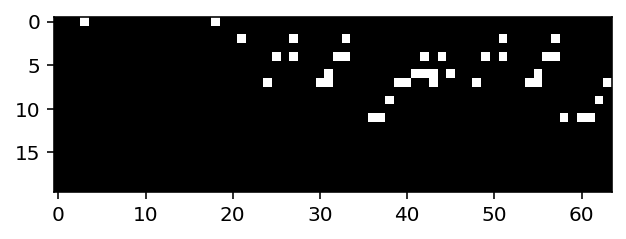

./generated/x_test_8.mid


Reproduction
Original Images


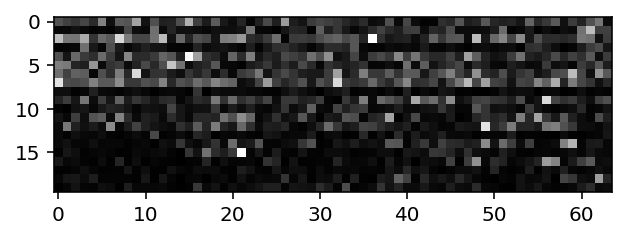

./generated/prediction_8.mid


Original
x_test_9.mid
Original Images


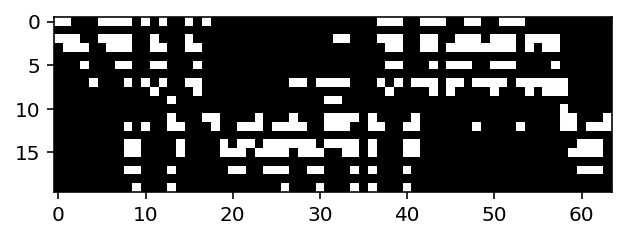

./generated/x_test_9.mid


Reproduction
Original Images


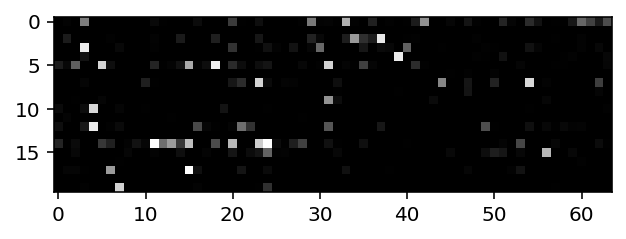

./generated/prediction_9.mid


Original
x_test_10.mid
Original Images


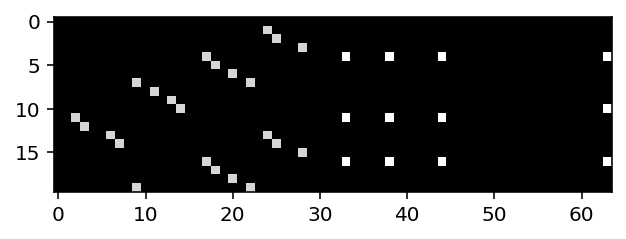

./generated/x_test_10.mid


Reproduction
Original Images


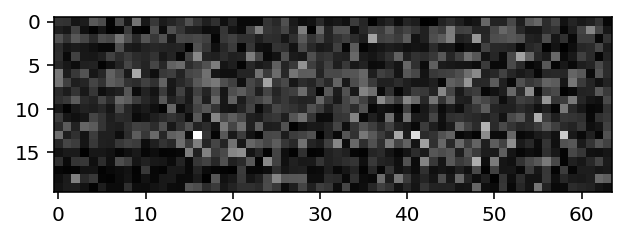

./generated/prediction_10.mid


Original
x_test_11.mid
Original Images


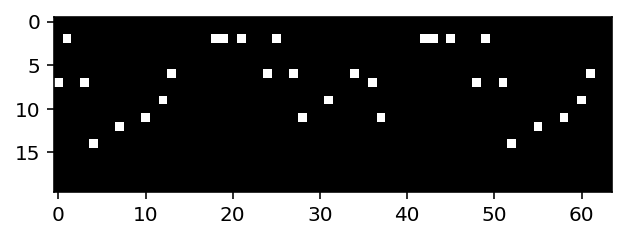

./generated/x_test_11.mid


Reproduction
Original Images


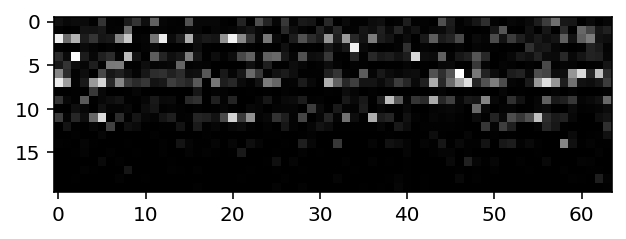

./generated/prediction_11.mid


Original
x_test_12.mid
Original Images


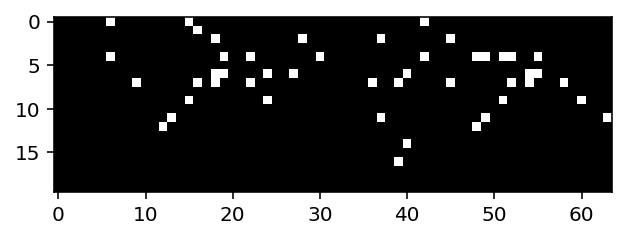

./generated/x_test_12.mid


Reproduction
Original Images


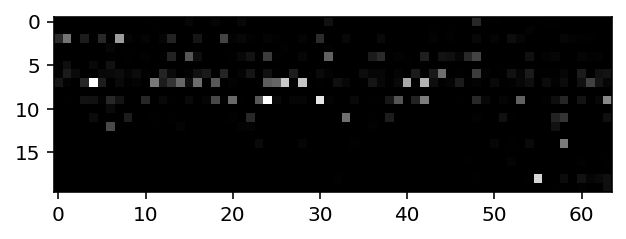

./generated/prediction_12.mid


Original
x_test_13.mid
Original Images


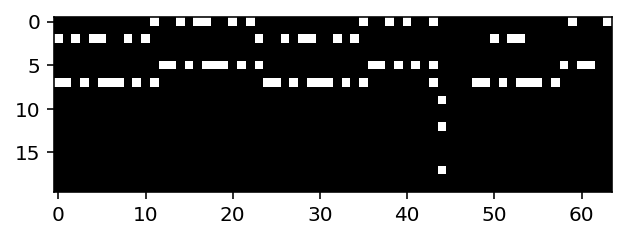

./generated/x_test_13.mid


Reproduction
Original Images


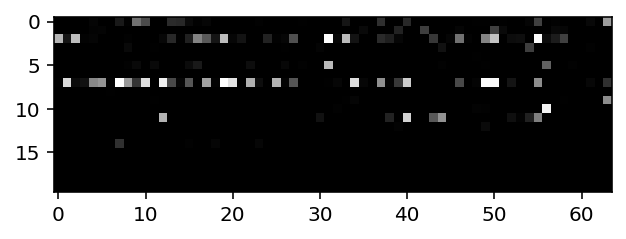

./generated/prediction_13.mid


Original
x_test_14.mid
Original Images


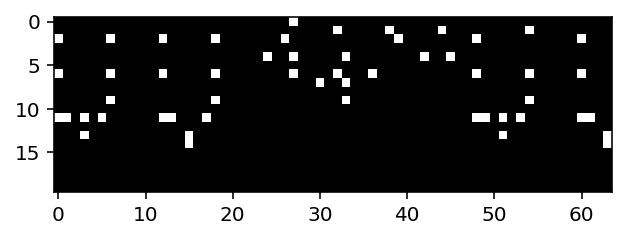

./generated/x_test_14.mid


Reproduction
Original Images


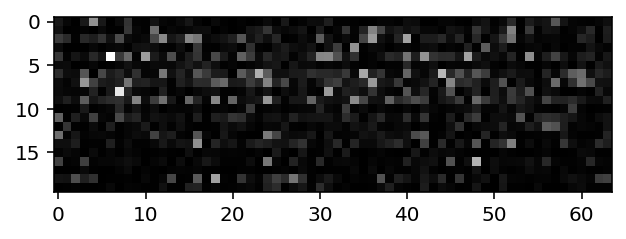

./generated/prediction_14.mid


Original
x_test_15.mid
Original Images


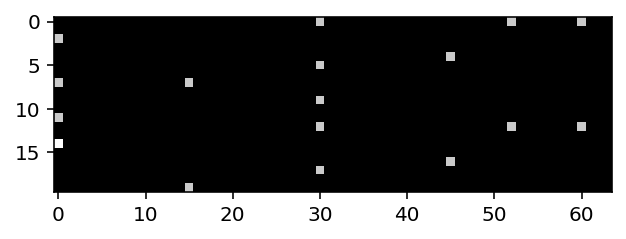

./generated/x_test_15.mid


Reproduction
Original Images


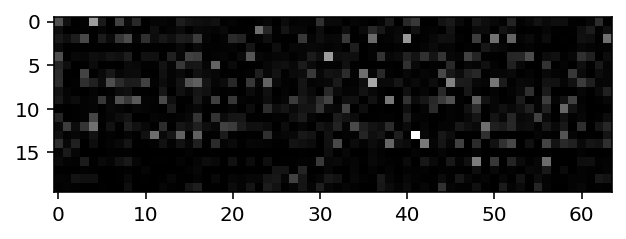

./generated/prediction_15.mid


Original
x_test_16.mid
Original Images


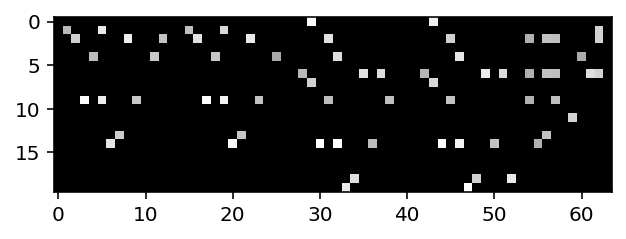

./generated/x_test_16.mid


Reproduction
Original Images


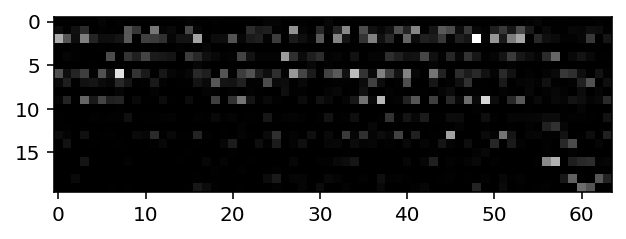

./generated/prediction_16.mid


Original
x_test_17.mid
Original Images


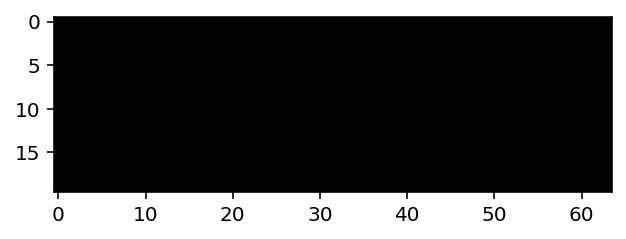

./generated/x_test_17.mid


Reproduction
Original Images


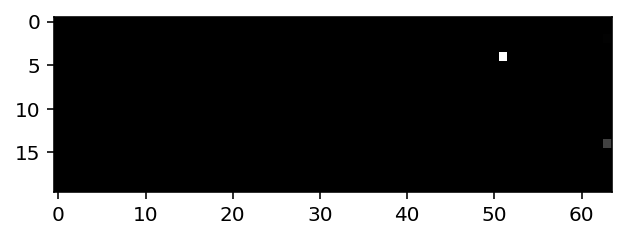

./generated/prediction_17.mid


Original
x_test_18.mid
Original Images


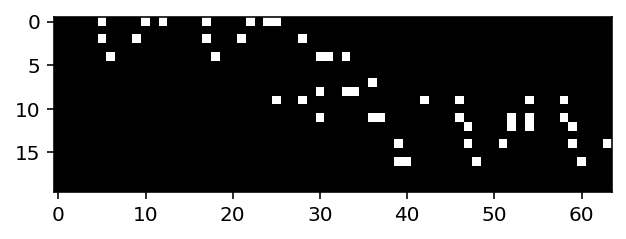

./generated/x_test_18.mid


Reproduction
Original Images


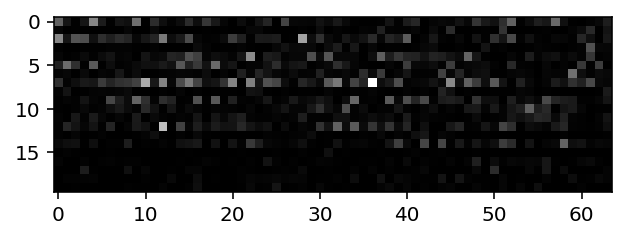

./generated/prediction_18.mid


Original
x_test_19.mid
Original Images


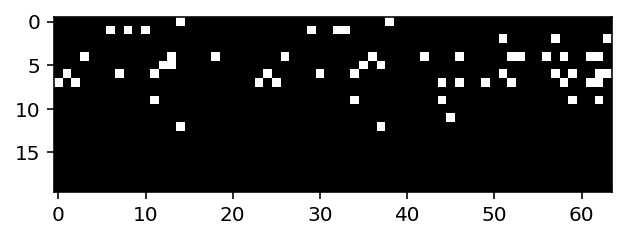

./generated/x_test_19.mid


Reproduction
Original Images


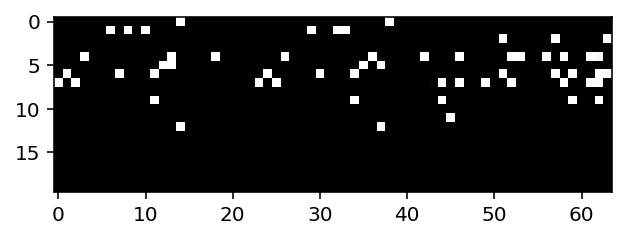

./generated/prediction_19.mid


In [15]:

# on new data using `predict`
print("Generate predictions for samples")
print(x_test.shape)
predictions = vae.predict(x_test)
print("predictions shape:", predictions.shape)
#print("predictions:", predictions);
for i in range(min(20,len(predictions))):
    canvas_recon = np.empty((HEIGHT, WIDTH))
    
    #print("File ", result[i].as_posix())
    
    print("Original")
    print("x_test_" + str(i) + ".mid")
    generateTrackImage(x_test[i])
    
    pattern = generateTrack(x_test[i])
    filename = "./generated/x_test_" + str(i) + ".mid"
    print(filename)
    midi.write_midifile(filename, pattern)
    s = converter.parse(filename)
    s.show('midi')
    
    print("Reproduction")
    generateTrackImage(predictions[i])
    
    pattern = generateTrack(predictions[i])
    filename = "./generated/prediction_" + str(i) + ".mid"
    print(filename)
    midi.write_midifile(filename, pattern)
    s = converter.parse(filename)
    s.show('midi')

## Generate new data

Original Images


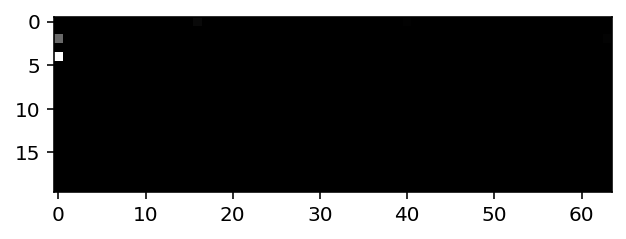

./generated/generation_0.mid


Original Images


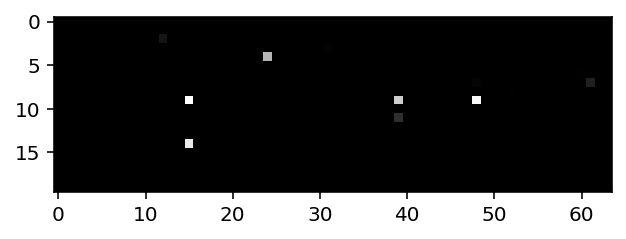

./generated/generation_1.mid


Original Images


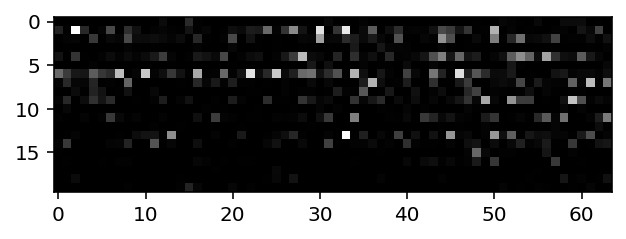

./generated/generation_2.mid


Original Images


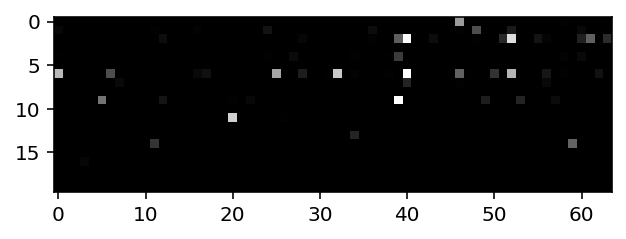

./generated/generation_3.mid


Original Images


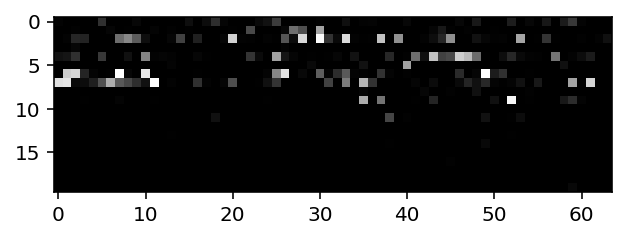

./generated/generation_4.mid


Original Images


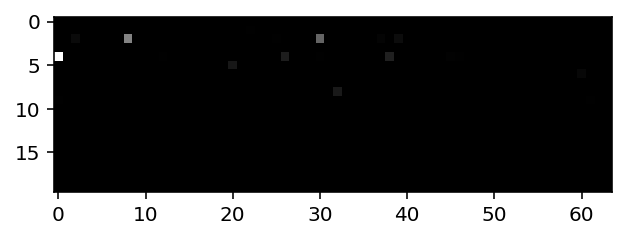

./generated/generation_5.mid


Original Images


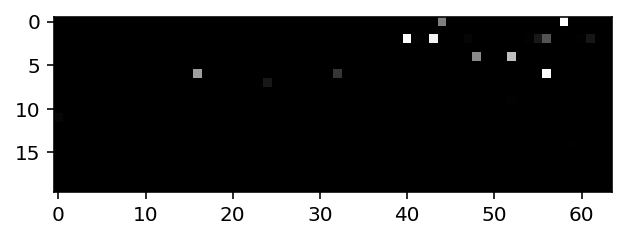

./generated/generation_6.mid


Original Images


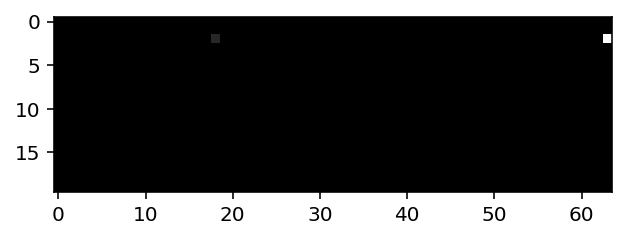

./generated/generation_7.mid


Original Images


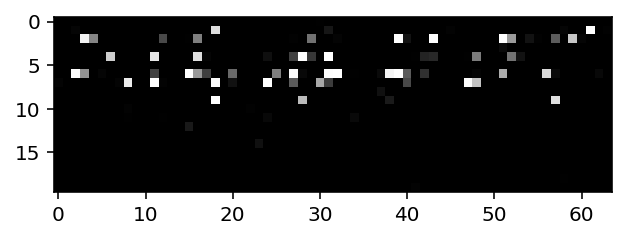

./generated/generation_8.mid


Original Images


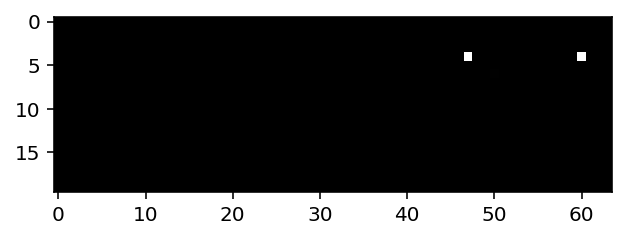

./generated/generation_9.mid


Original Images


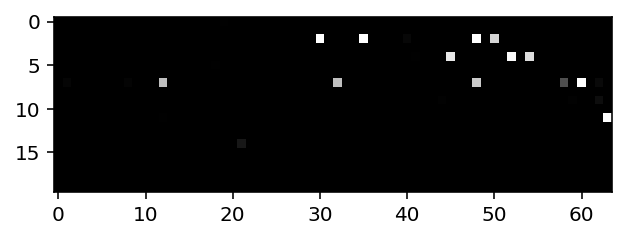

./generated/generation_10.mid


Original Images


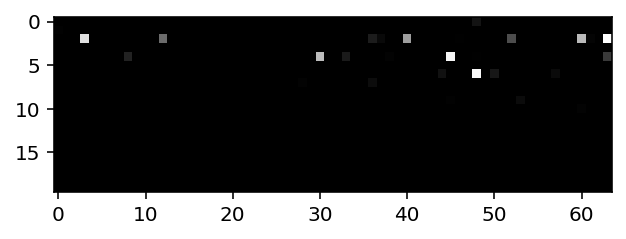

./generated/generation_11.mid


Original Images


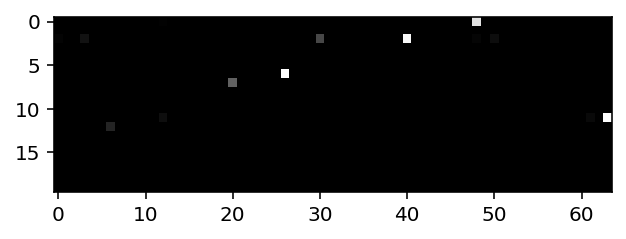

./generated/generation_12.mid


Original Images


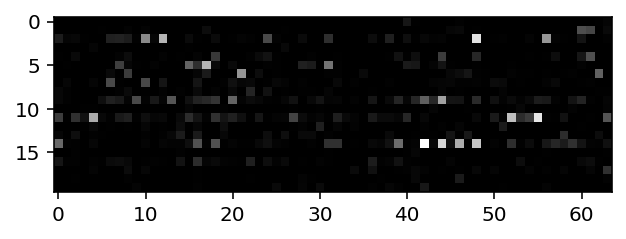

./generated/generation_13.mid


Original Images


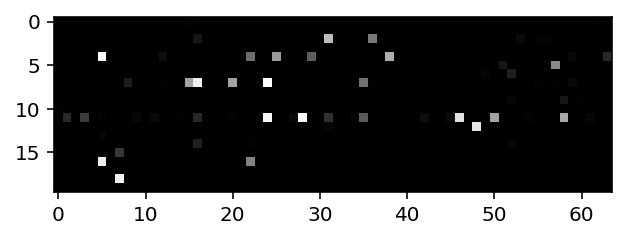

./generated/generation_14.mid


Original Images


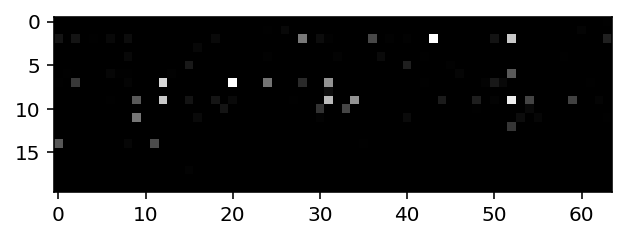

./generated/generation_15.mid


Original Images


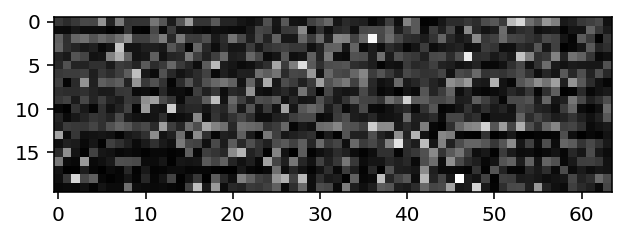

./generated/generation_16.mid


Original Images


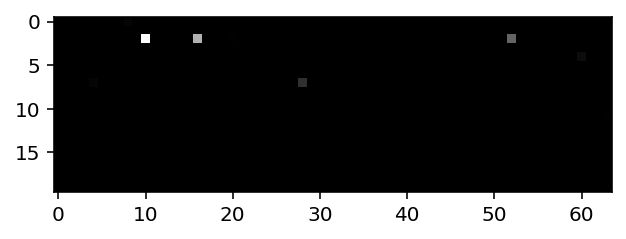

./generated/generation_17.mid


Original Images


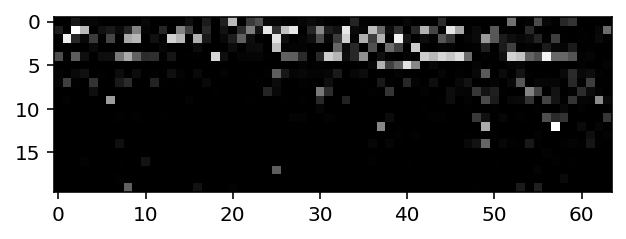

./generated/generation_18.mid


Original Images


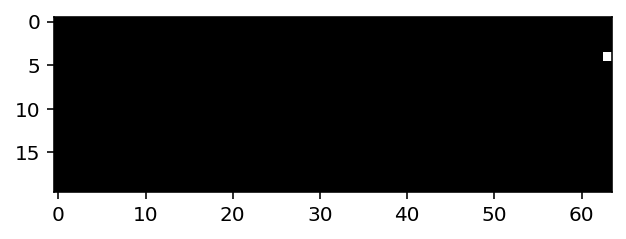

./generated/generation_19.mid


In [16]:
n_to_show = 20
reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,LATENT_SPACE)))

for i in range(n_to_show):
    generateTrackImage(reconst_images[i])
    pattern = generateTrack(predictions[i])
    filename = "./generated/generation_" + str(i) + ".mid"
    print(filename)
    midi.write_midifile(filename, pattern)
    s = converter.parse(filename)
    s.show('midi')